Кирилл Лалаянц, R33352

# Лабораторная работа No8
# В -- 11
## Модальные регуляторы и наблюдатели

Импорт необходимых для работы библиотек. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 
import array_to_latex as a2l
# plt.rcParams['text.usetex'] = True

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)
# np.set_printoptions(precision=1, suppress=True)
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

## Task1

In [4]:
task1_A = np.array([
    [-4, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 5],
    [0, 0, -5, 1]
])

task1_B = np.array([[0], 
                    [2], 
                    [0], 
                    [9]])

task1_specs = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])

task1_x0 = np.array([1, 1, 1, 1])

print(a2l.to_ltx(task1_specs, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -4.00 + 0.00j & -4.00 + 0.00j & -4.00 + 0.00j & -4.00 + 0.00j\\
 -4.00 + 0.00j & -40.00 + 0.00j & -400.00 + 0.00j & -400.00 + 0.00j\\
 -4.00 + 0.00j & -8.00 + 0.00j &  0.00 + 5.00j &  -0.00 + -5.00j\\
 -4.00 + 0.00j & -8.00 + 0.00j & -1.00 + 5.00j & -1.00 + -5.00j
\end{bmatrix}


In [5]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    U = get_controllability_matrix(A, B)
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    return np.linalg.matrix_rank(U) == A.shape[0]
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability(C, A):
    V = get_observability_matrix(A, C)
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    return np.linalg.matrix_rank(V) == A.shape[0]

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")


def task1_get_K(A, B, G, Y):
    P= cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(A @ P - P @ G - B @ Y))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(P.value)}')
    return - Y @ np.linalg.pinv(P.value)

def task1_get_G(specs):
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
        if new_g[i, i] == new_g[i-1, i-1]:
            new_g[i-1, i] = 1
    if specs[2].imag != 0:
        new_g[2, 2] = specs[2].real
        new_g[3, 3] = specs[2].real
        new_g[2, 3] = specs[2].imag
        new_g[3, 2] = -specs[2].imag
    return new_g

def task1_get_G_bad(specs):
    base = []
    for i in range(len(specs)):
        rolled = np.array(np.roll([i + 1 for i in range(len(specs))], i))
        base.append(rolled)
    base = np.array(base)
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
            if new_g[i, i] == new_g[i-1, i-1]:
                new_g[i-1, i] = 1
    if specs[2].imag != 0:
            new_g[2, 2] = specs[2].real
            new_g[3, 3] = specs[2].real
            new_g[2, 3] = specs[2].imag
            new_g[3, 2] = -specs[2].imag
        
    new_g = base @ new_g @ np.linalg.inv(base)
    return new_g
    
    
def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}')
    ss = control.ss(A + B@K, A*0, A*0, A*0)
    return control.forced_response(ss, X0=x0, T=ts)

In [6]:
check_controllability_eigens(task1_A, task1_B)

Eigen values of A:
   [1.+5.j]: controllable
   [1.-5.j]: controllable
   [-4.+0.j]: not controllable
   [1.+0.j]: controllable



======== [-4.+0.j -4.+0.j -4.+0.j -4.+0.j] ========
Optimization error: 4.2401273655629385e-30, rankP = 3
RankV = 3
Eigen values of A:
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
K = [[-1.11099932e-14 -2.50000000e+00 -1.11111111e+00 -1.11111111e+00]]
\begin{bmatrix}
 -0.00 & -2.50 & -1.11 & -1.11
\end{bmatrix}
spec(A + B@K): [-4.00007152+0.00012388j -4.00007152-0.00012388j -3.99985696+0.j
 -4.        +0.j        ]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [  -4.+0.j  -40.+0.j -400.+0.j -400.+0.j] ========
Optimization error: 1.622191532857925e-29, rankP = 3
RankV = 3
Eigen values of A:
   [-4.+0.j]: not observable
   [-40.+0.j]: observable
   [-400.+0.j]: observable
   [-400.+0.j]: observable
K = [[      0.         -131856.82000268   -4303.51111119   29207.84888948]]
\begin{bmatrix}
  0.00 & -131856.82 & -4303.51 &  29207.85
\end{bmatrix}
spec(A + B@K): [-400.00632888 -399.99367112  -40.           -4.        ]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j  0.+5.j -0.-5.j] ========
Optimization error: 3.870348816240589e-29, rankP = 3
RankV = 3
Eigen values of A:
   [0.+5.j]: observable
   [-2.22044605e-16-5.j]: observable
   [-4.+0.j]: not observable
   [-8.+0.j]: observable
K = [[ 0.         -4.68       -0.42222222 -0.18222222]]
\begin{bmatrix}
  0.00 & -4.68 & -0.42 & -0.18
\end{bmatrix}
spec(A + B@K): [ 1.69086216e-15+5.j  1.69086216e-15-5.j -8.00000000e+00+0.j
 -4.00000000e+00+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j -1.+5.j -1.-5.j] ========
Optimization error: 1.9721522630525295e-29, rankP = 3
RankV = 3
Eigen values of A:
   [-1.+5.j]: observable
   [-1.-5.j]: observable
   [-4.+0.j]: not observable
   [-8.+0.j]: observable
K = [[ 0.         -5.22       -0.88888889 -0.28444444]]
\begin{bmatrix}
  0.00 & -5.22 & -0.89 & -0.28
\end{bmatrix}
spec(A + B@K): [-1.+5.j -1.-5.j -8.+0.j -4.+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


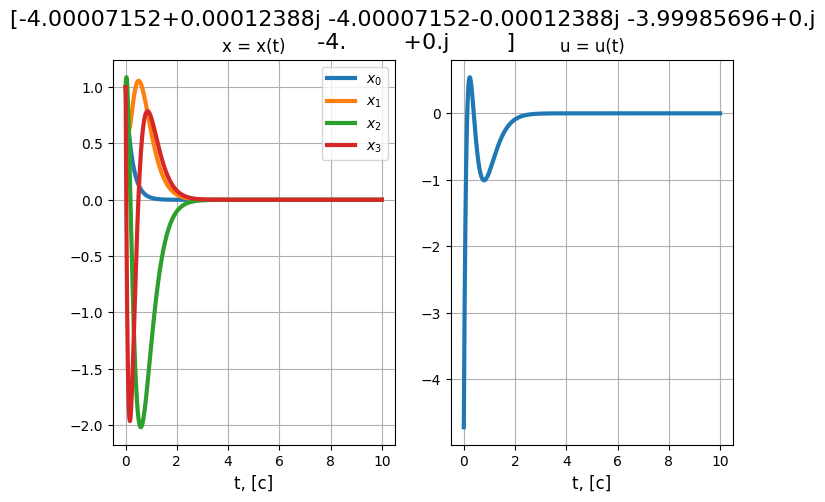

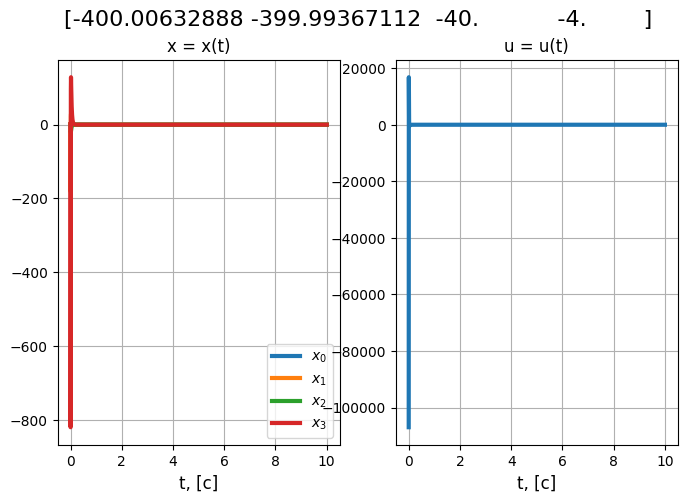

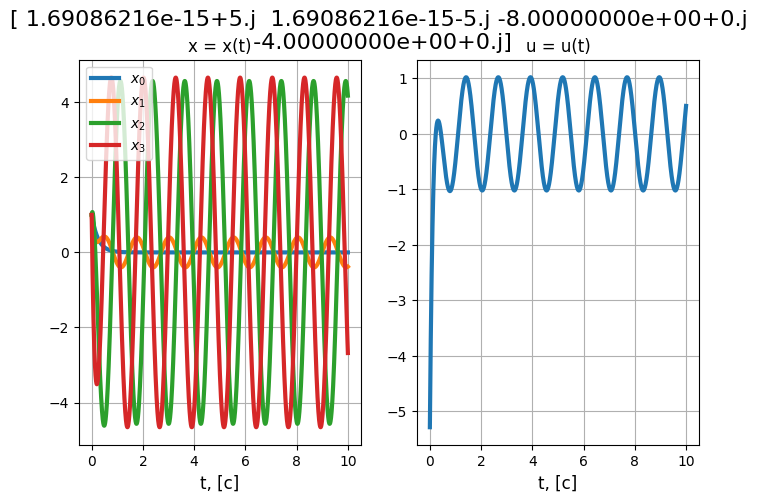

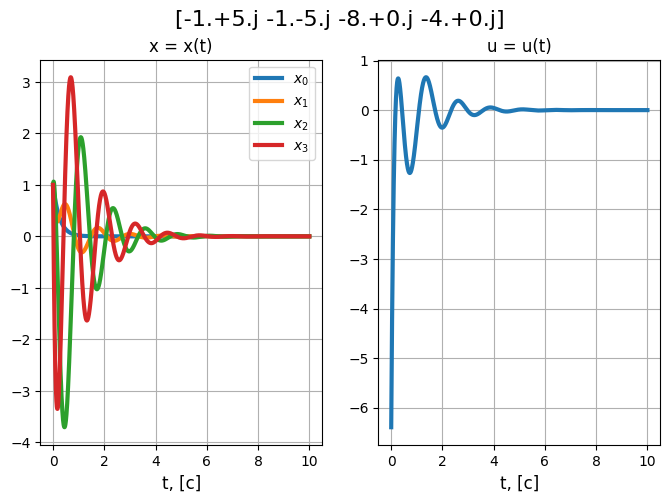

In [7]:
task1_ks = dict()
for indx, specs in enumerate(task1_specs):
    print(f'\n======== {specs} ========')
    new_g = task1_get_G(specs)
    new_y = np.ones((task1_B.shape[1], task1_A.shape[0]))
    new_y[0, 0] = 0
    # print(f'G:\n{new_g}')
    # print(f'Y:\n{new_y}')
    
    K = task1_get_K(task1_A, task1_B, new_g, new_y).astype(np.float64)
    task1_ks[indx] = K
    check_observability(new_y, new_g)
    check_observability_eigens(new_y, new_g)
    
    print(f'K = {K}')
    print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
    
    ts = get_t(10)
    res = task1_simulate(task1_A, task1_B, K, task1_x0, ts)

    fig, axs = plt.subplots(1, 2, figsize=(8, 5))
    fig.suptitle(f'{np.linalg.eigvals(task1_A + task1_B @ K)}', fontsize=16)
    for i in range(4):
        axs[0].plot(ts, res.states[i], linewidth = 3, label=f'$x_{i}$')
    axs[0].grid(True)
    axs[0].legend()
    axs[0].set_title(f'x = x(t)', fontsize=12)
    axs[0].set_xlabel(f"t, [c]", fontsize=12)

    axs[1].plot(ts, (K @ res.states).reshape(-1), linewidth = 3)
    axs[1].grid(True)
    axs[1].set_title(f'u = u(t)', fontsize=12)
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    plt.savefig(f'{SAVE_PATH}/task1_{indx}.jpg')

## Task 2

In [8]:
task2_A = np.array([
    [0, 4, 0, 0],
    [-4, 0, 0, 0],
    [0, 0, 0, 3],
    [0, 0, -3, 0]
])

task2_C = np.array([[5, 0, 0, 9]])

task2_specs = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])

task2_x0 = np.array([1, 1, 1, 1])
task2_xh0 = np.array([2, 0, 0, -1])

In [9]:
np.zeros((task2_A.shape[0], 1))

array([[0.],
       [0.],
       [0.],
       [0.]])

In [10]:
def task2_simulate(A, C, L, x0, xh0, ts):
    ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), C, np.zeros((C.shape[0], 1)))
    original_resp = control.forced_response(ss_orig, X0=x0, T=ts)
    ss = control.ss(A + L@C, L, A*0, L*0)
    return original_resp, control.forced_response(ss, X0=xh0, T=ts, U=original_resp.outputs.reshape(-1))

def task2_get_L(A, C, G, Y):
    Q = cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(G @ Q - Q @ A - Y @ C))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(Q.value)}')
    return np.linalg.pinv(Q.value) @ Y

In [11]:
check_observability_eigens(task2_C, task2_A)

Eigen values of A:
   [0.+4.j]: observable
   [0.-4.j]: observable
   [0.+3.j]: observable
   [0.-3.j]: observable


In [12]:
for indx, specs in enumerate(task1_specs):
    print(f'\n======== {specs} ========')
    new_g = task1_get_G(specs)
    new_y = np.ones((task1_A.shape[0], task2_C.shape[0]))
    
    L = task2_get_L(task2_A, task2_C, new_g, new_y).astype(np.float64)
    check_controllability(new_g, new_y)
    check_controllability_eigens(new_g, new_y)
    
    print(f'L = {L}')
    print(a2l.to_ltx(L.T, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
    print(np.linalg.eigvals(task2_A + L @ task2_C))
    
    ts = get_t(10)
    original_resp, observer_resp = task2_simulate(task2_A, task2_C, L, task2_x0, task2_xh0, ts)

    fig, axs = plt.subplots(2, 2, figsize=(8, 5))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(original_resp.states.shape[0]):
        axs[i//2, i % 2].plot(ts, original_resp.states[i], color='r', linewidth=4, label='system')
        axs[i//2, i % 2].plot(ts, -observer_resp.states[i], '--', color='g', linewidth = 2, label='observer')
        axs[i//2, i % 2].set_title(f'$x_{i} = x_{i}(t)$', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
    plt.savefig(f'{SAVE_PATH}/task2_states_{indx}.jpg')
    plt.close()

    plt.plot(ts, original_resp.outputs.reshape(-1), linewidth = 3, label='system')
    plt.plot(ts, -(task2_C @ observer_resp.states).reshape(-1), '--', linewidth = 3, label='observer')
    plt.plot(ts, original_resp.outputs.reshape(-1) + (task2_C @ observer_resp.states).reshape(-1), '--', linewidth = 3, label='error')
    
    plt.grid(True)
    plt.legend()
    plt.title(f'y = y(t)', fontsize=12)
    plt.xlabel(f"t, [c]", fontsize=12)
    plt.savefig(f'{SAVE_PATH}/task2_y_{indx}.jpg')
    plt.close()


======== [-4.+0.j -4.+0.j -4.+0.j -4.+0.j] ========
Optimization error: 7.888609052210118e-31, rankP = 4
RankU = 4
Eigen values of A:
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
L = [[ 1.02318154e-12]
 [-7.31428571e+00]
 [-2.78835979e+00]
 [-1.77777778e+00]]
\begin{bmatrix}
  0.00 & -7.31 & -2.79 & -1.78
\end{bmatrix}
[-4.0023962+0.00239689j -4.0023962-0.00239689j -3.9976038+0.00239551j
 -3.9976038-0.00239551j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [  -4.+0.j  -40.+0.j -400.+0.j -400.+0.j] ========
Optimization error: 1.581429225584969e-30, rankP = 4
RankU = 4
Eigen values of A:
   [-4.+0.j]: controllable
   [-40.+0.j]: controllable
   [-400.+0.j]: controllable
   [-400.+0.j]: controllable
L = [[ 204414.17144307]
 [ 160532.11429733]
 [ 126147.30688737]
 [-113657.20635726]]
\begin{bmatrix}
  204414.17 &  160532.11 &  126147.31 & -113657.21
\end{bmatrix}
[-400.00000183+0.04118859j -400.00000183-0.04118859j
  -39.99999627+0.j           -4.00000005+0.j        ]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j  0.+5.j -0.-5.j] ========
Optimization error: 7.099748146989106e-30, rankP = 4
RankU = 4
Eigen values of A:
   [0.+5.j]: controllable
   [-2.22044605e-16-5.j]: controllable
   [-4.+0.j]: controllable
   [-8.+0.j]: controllable
L = [[ 3.08571429]
 [ 1.02857143]
 [ 1.94708995]
 [-3.04761905]]
\begin{bmatrix}
  3.09 &  1.03 &  1.95 & -3.05
\end{bmatrix}
[-3.84734208e-15+5.j -3.84734208e-15-5.j -8.00000000e+00+0.j
 -4.00000000e+00+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j -1.+5.j -1.-5.j] ========
Optimization error: 1.4396711520283465e-29, rankP = 4
RankU = 4
Eigen values of A:
   [-1.+5.j]: controllable
   [-1.-5.j]: controllable
   [-4.+0.j]: controllable
   [-8.+0.j]: controllable
L = [[ 4.34285714]
 [-1.6       ]
 [ 0.92592593]
 [-3.96825397]]
\begin{bmatrix}
  4.34 & -1.60 &  0.93 & -3.97
\end{bmatrix}
[-8.+0.j -1.+5.j -1.-5.j -4.+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


## Task 3

In [13]:
task3_A = np.array([
    [5, -5, -9, 3],
    [-5, 5, -3, 9],
    [-9, -3, 5, 5],
    [3, 9, 5, 5]
])

task3_B = np.array([[2], 
                    [6], 
                    [6], 
                    [2]])

task3_C = np.array([
    [1, -1, 1, 1],
    [1, 3, -1, 3]
                    ])

specs = [-12, -3, -2, -1]
# specs = [-12, -0.1, -0.2, -0.3]


In [14]:
check_controllability_eigens(task3_A, task3_B)

Eigen values of A:
   [-12.]: controllable
   [4.]: controllable
   [16.]: controllable
   [12.]: controllable


In [15]:
# specs = [-4, -1, -2, -3]
new_g = task1_get_G(specs)
new_y = np.ones((task3_B.shape[1], task3_A.shape[0]))
# print(f'G:\n{new_g}')
# print(f'Y:\n{new_y}')

K = task1_get_K(task3_A, task3_B, new_g, new_y).astype(np.float64)
check_observability(new_y, new_g)
check_observability_eigens(new_y, new_g)

Optimization error: 36.0, rankP = 4
RankV = 4
Eigen values of A:
   [-12.]: observable
   [-3.]: observable
   [-2.]: observable
   [-1.]: observable


In [16]:
check_observability_eigens(task3_C, task3_A)

Eigen values of A:
   [-12.]: not observable
   [4.]: observable
   [16.]: observable
   [12.]: observable


In [17]:
# specs = [-12, -1, -2, -3]
new_g = task1_get_G(specs)
new_y = np.ones((task3_A.shape[0], task3_C.shape[0]))

new_y[0, :] = 0
print(new_y)


L = task2_get_L(task3_A, task3_C, new_g, new_y).astype(np.float64)
check_controllability(new_g, new_y)
check_controllability_eigens(new_g, new_y)

[[0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Optimization error: 4.213164346341517e-30, rankP = 3
RankU = 3
Eigen values of A:
   [-12.]: not controllable
   [-3.]: controllable
   [-2.]: controllable
   [-1.]: controllable


In [18]:
task3_new_A = np.block([[task3_A + task3_B @ K, -task3_B @ K], [np.zeros((task3_A.shape[0], K.shape[1] * 2 - task3_C.shape[1])), task3_A + L @ task3_C]])
task3_new_A

array([[  81.64226417,   25.40461259,  -88.86227613,   30.56318835,
         -76.64226417,  -30.40461259,   79.86227613,  -27.56318835],
       [ 224.92679252,   96.21383777, -242.5868284 ,   91.68956504,
        -229.92679252,  -91.21383777,  239.5868284 ,  -82.68956504],
       [ 220.92679252,   88.21383777, -234.5868284 ,   87.68956504,
        -229.92679252,  -91.21383777,  239.5868284 ,  -82.68956504],
       [  79.64226417,   39.40461259,  -74.86227613,   32.56318835,
         -76.64226417,  -30.40461259,   79.86227613,  -27.56318835],
       [   0.        ,    0.        ,    0.        ,    0.        ,
          85.796875  ,   75.796875  ,   -9.        ,  164.59375   ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
         -43.140625  ,  -33.140625  ,   -3.        ,  -67.28125   ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
         -91.984375  ,  -85.984375  ,    5.        , -160.96875   ],
       [   0.        ,    0.        ,    

In [19]:
ss = control.ss(task3_new_A, task3_new_A * 0, task3_new_A * 0, task3_new_A * 0)

ts = get_t(15)
res = control.forced_response(ss, T=ts, X0=np.ones((task3_A.shape[0]*2)))
x = res.states[:4]
e = res.states[4:]

xh = x - e
y = task3_C @ x
yh = task3_C @ xh

u = K @ xh

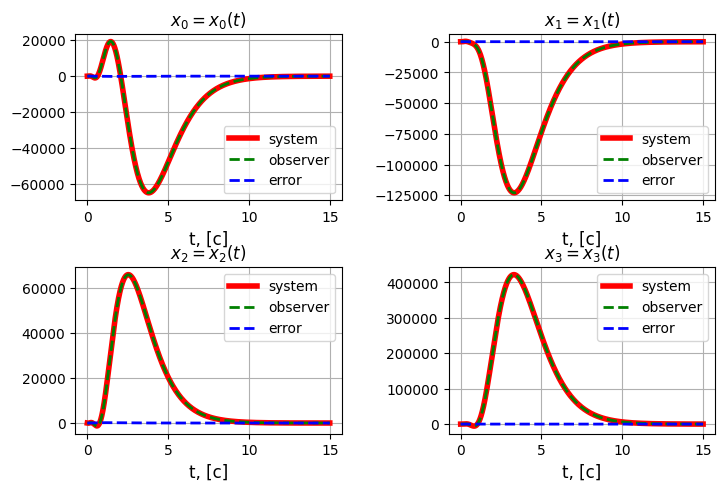

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for i in range(original_resp.states.shape[0]):
    axs[i//2, i % 2].plot(ts, x[i], color='r', linewidth=4, label='system')
    axs[i//2, i % 2].plot(ts, xh[i], '--', color='g', linewidth = 2, label='observer')
    axs[i//2, i % 2].plot(ts, e[i], '--', color='b', linewidth = 2, label='error')
    axs[i//2, i % 2].set_title(f'$x_{i} = x_{i}(t)$', fontsize=12)
    axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i % 2].grid(True)
    axs[i//2, i % 2].legend()
plt.savefig(f'{SAVE_PATH}/task3_states.jpg')

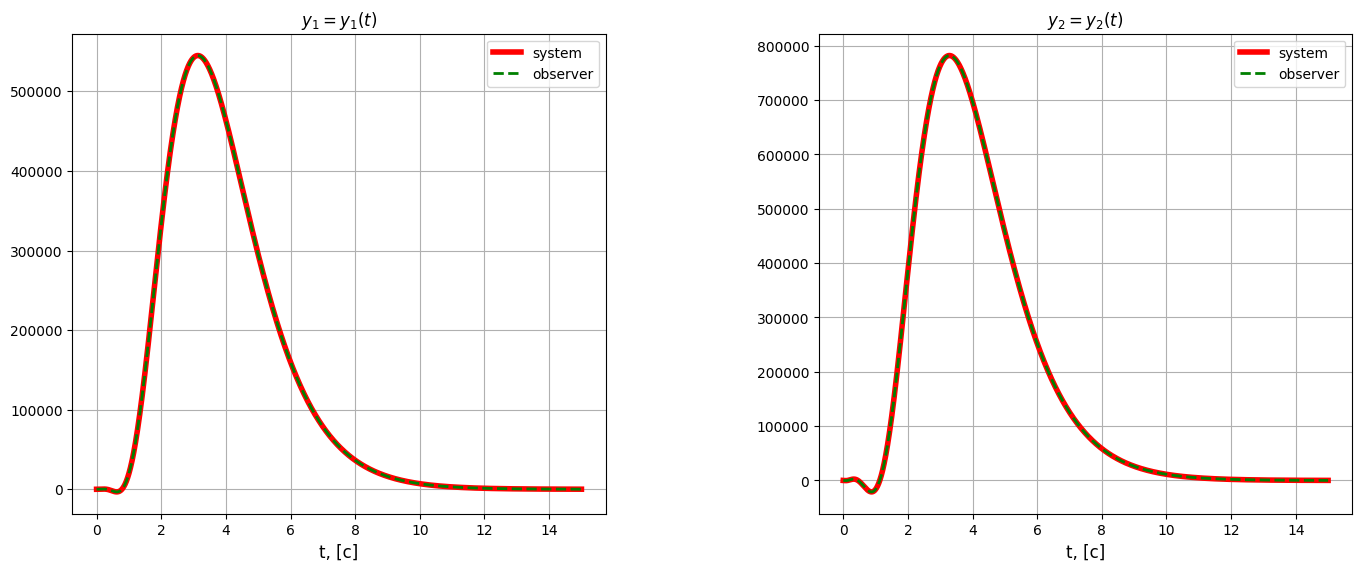

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

axs[0].plot(ts, y[0], color='r', linewidth=4, label='system')
axs[0].plot(ts, yh[0], '--', color='g', linewidth = 2, label='observer')
axs[0].set_title(f'$y_1 = y_1(t)$', fontsize=12)
axs[0].set_xlabel(f"t, [c]", fontsize=12)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(ts, y[1], color='r', linewidth=4, label='system')
axs[1].plot(ts, yh[1], '--', color='g', linewidth = 2, label='observer')
axs[1].set_title(f'$y_2 = y_2(t)$', fontsize=12)
axs[1].set_xlabel(f"t, [c]", fontsize=12)
axs[1].grid(True)
axs[1].legend()


plt.savefig(f'{SAVE_PATH}/task3_y.jpg')

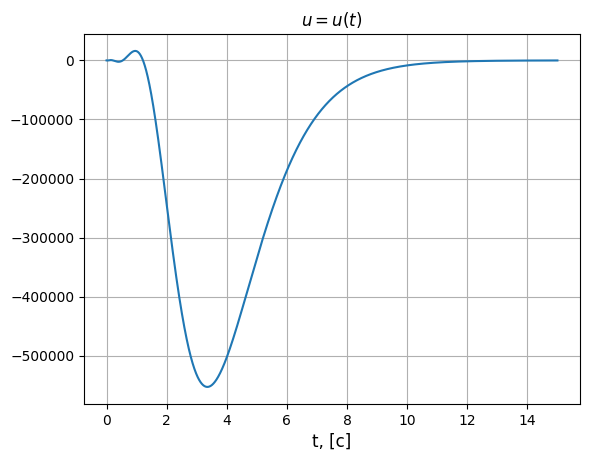

In [22]:
plt.plot(ts, u.reshape(-1))
plt.title(f'$u = u(t)$', fontsize=12)
plt.xlabel(f"t, [c]", fontsize=12)
plt.grid(True)
plt.savefig(f'{SAVE_PATH}/task3_u.jpg')

In [23]:
a2l.to_ltx(K)

\begin{bmatrix}
  38.32 &  15.20 & -39.93 &  13.78
\end{bmatrix}


In [24]:
ss_system_A = task3_A
ss_system_B = task3_B @ K
ss_system_C = task3_C
ss_system_D = np.zeros((task3_C.shape[0], ss_system_B.shape[1]))

In [25]:
ss_observer_A = task3_A + L @ task3_C + task3_B @ K
ss_observer_B = -L
ss_observer_C = task3_C
ss_observer_D = np.zeros((task3_C.shape[0], ss_observer_B.shape[1]))

(15000, 2, 1) (15000, 2, 1) (15000, 4, 1) (15000, 4, 1)


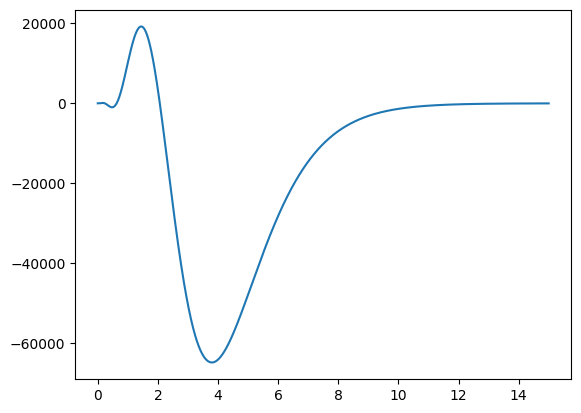

In [34]:
max_t = 15
dt = 1e-3
t = [0]

xhs = np.array([[0, 0, 0, 0]]).reshape(1, 4, 1)
yhs = np.array([ss_observer_C @ xhs[-1]]).reshape(1, 2, 1)


xs = np.array([[1, 1, 1, 1]]).reshape(1, 4, 1)
ys = np.array([ss_system_C @ xs[-1]]).reshape(1, 2, 1)


while len(t) < max_t / dt:
    t.append(t[-1] + dt)
    
    dxh = ss_observer_A @ xhs[-1] + ss_observer_B @ ys[-1]
    xhs = np.vstack((xhs, (xhs[-1] + dxh * dt).reshape(1, 4, 1)))
    yhs = np.vstack((yhs, (ss_system_C @ xhs[-1]).reshape(1, 2, 1)))
    
    dx = ss_system_A @ xs[-1] + ss_system_B @ xhs[-1]
    xs = np.vstack((xs, (xs[-1] + dx * dt).reshape(1, 4, 1)))
    ys = np.vstack((ys, (ss_system_C @ xs[-1]).reshape(1, 2, 1)))
print(ys.shape, yhs.shape, xs.shape, xhs.shape)

# plt.plot(t, xs[:, 0])
plt.plot(t, x[0])
